# Advanced usage

Like ``hdbscan``, ``plscan`` supports several advanced use cases. Let's load
libraries and grab some data to demonstrate:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from plscan import PLSCAN

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (2.75, 0.618 * 2.75)

mst = np.load("data/mst.npy")
data = np.load("data/data.npy")

## Exploration plots

`plscan` contains several attributes for inspecting the cluster hierarchy.

### Condensed tree

Like `hdbscan`, `plscan` has a condensed tree showing the cluster hierarchy
along data point distances. Unlike `hdbscan`, `plscan` uses distances rather
than density estimates to plot the tree.

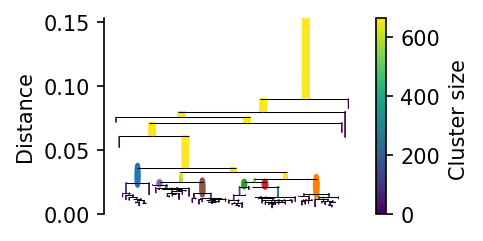

In [17]:
c = PLSCAN().fit(data)

c.condensed_tree_.plot(select_clusters=True, distance_ranks=False)
plt.show()

The `distance_cut()` method can be used to extract clusters at a given distance:

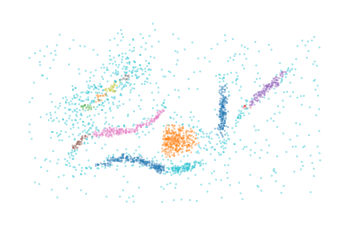

In [23]:
labels, probs = c.distance_cut(0.015)
plt.scatter(*data.T, c=labels % 10, s=1, alpha=0.4, linewidth=0, cmap="tab10")
plt.axis("off")
plt.show()

### Leaf tree

`plscan` does not extract clusters from the condensed tree directly. Instead, it
first creates a cluster hierarchy describing which clusters exist at each minimum cluster size value. The `leaf_tree_` attribute contains this hierarchy:

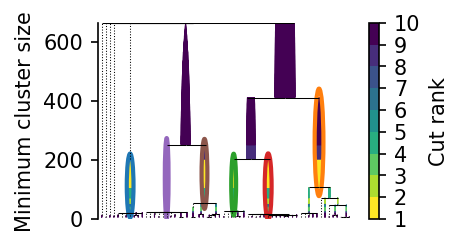

In [51]:
c = PLSCAN().fit(data)

c.leaf_tree_.plot(select_clusters=True, leaf_separation=0.1)
plt.show()

The `min_cluster_size_cut()` method can be used to extract clusters at a given minimum cluster size:

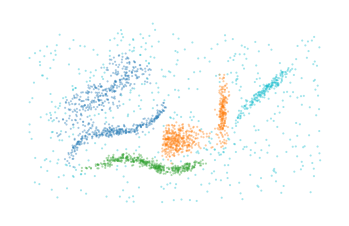

In [27]:
labels, probs = c.min_cluster_size_cut(300)
plt.scatter(*data.T, c=labels % 10, s=1, alpha=0.4, linewidth=0, cmap="tab10")
plt.axis("off")
plt.show()

### Persistence trace

`plscan` extracts clusters from the leaf tree by computing each leaf cluster's
persistence and finding the minimum cluster size with the highest leaf-cluster
persistence sum. The `persistence_trace_` attribute can plot this minimum
cluster size -- persistence trace.

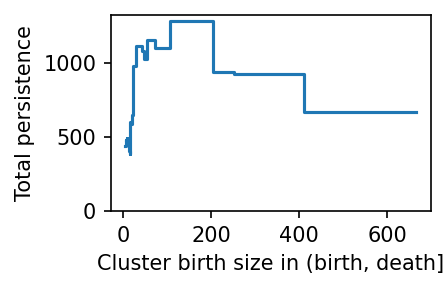

In [28]:
c.persistence_trace_.plot()
plt.show()

By default, the minimum cluster size with the highest persistence value is
selected. Other interesting clusterings can be explored using the
`cluster_layers` method:

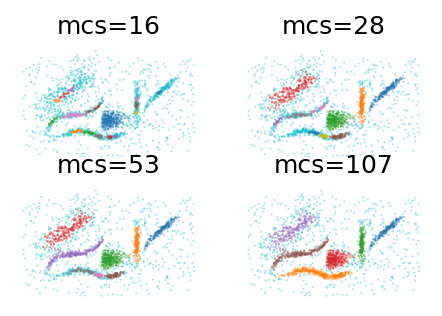

In [29]:
layers = c.cluster_layers(n_peaks=4)

for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(2, 2, i + 1)
    plt.scatter(*data.T, c=labels % 10, s=1, alpha=0.4, linewidth=0, cmap="tab10")
    plt.title(f"mcs={int(size)}")  # mcs = min cluster size
    plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

These interesting clusterings relate to peaks in the
minimum_cluster_size--persistence curve:

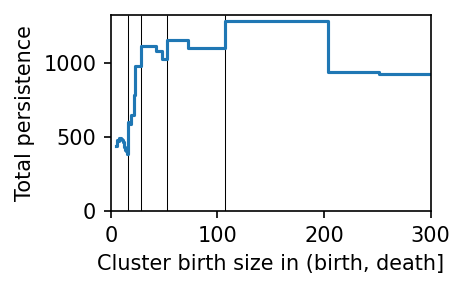

In [32]:
c.persistence_trace_.plot()
plt.vlines(list(zip(*layers))[0], *plt.ylim(), color="k", linewidth=0.5, zorder=1)
plt.xlim([0, 300])
plt.show()

## Distance metrics


`plscan` supports several distance metrics. The [basic usage
page](./basic_usage.ipynb) demonstrated the most common input type:
feature-vector with Euclidean distance. This section demonstrates the other
options:


### Non Euclidean distances

``plscan`` uses ``scikit-learn``'s kd-tree and ball-tree to efficiently find
neighbors and compute the minimum spanning tree. All distance metrics supported
by these space trees are also supported by ``plscan``. 


In [3]:
PLSCAN.valid_balltree_metrics

['euclidean',
 'l2',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity',
 'minkowski',
 'p',
 'seuclidean',
 'braycurtis',
 'canberra',
 'haversine',
 'mahalanobis',
 'hamming',
 'dice',
 'jaccard',
 'russellrao',
 'rogerstanimoto',
 'sokalsneath']

For example, using the minkowski distance with power factor 3.3:

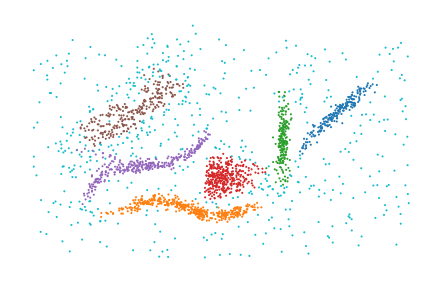

In [4]:
labels = PLSCAN(
    space_tree="ball_tree", metric="minkowski", metric_kws=dict(p=3.3)
).fit_predict(data)

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

### Precomputed distances

``plscan`` supports pre-computed distance in several formats:

- (sparse) distance matrices:

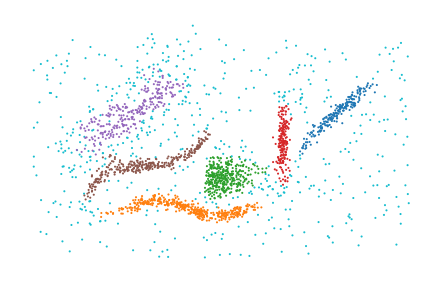

In [5]:
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(data)
labels = PLSCAN(metric="precomputed").fit_predict(dists)

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

- condensed distance matrices:

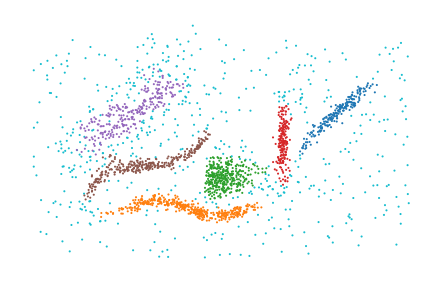

In [6]:
from scipy.spatial.distance import pdist

dists = pdist(data)
labels = PLSCAN(metric="precomputed").fit_predict(dists)

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

- precomputed minimum spanning trees:

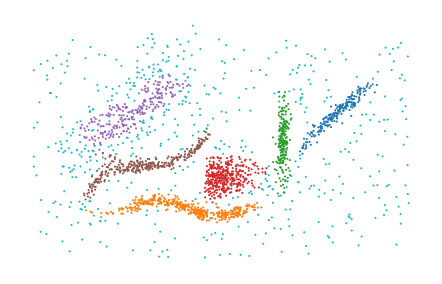

In [7]:
# min_samples=5 matches the precomputed MST.
labels = PLSCAN(min_samples=5, metric="precomputed").fit_predict((mst, data.shape[0]))

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

- k-nearest neighbors lists

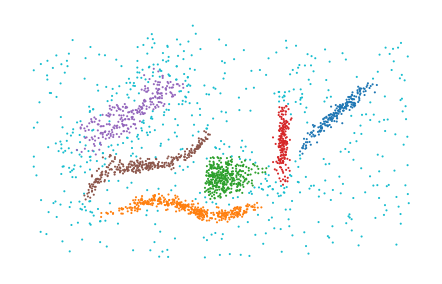

In [8]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10).fit(data).kneighbors(data)
labels = PLSCAN(metric="precomputed").fit_predict(knn)

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

- sparse distance matrices:

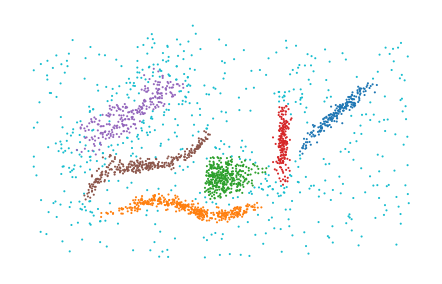

In [9]:
g_knn = (
    NearestNeighbors(n_neighbors=10).fit(data).kneighbors_graph(data, mode="distance")
)
labels = PLSCAN(metric="precomputed").fit_predict(g_knn)

plt.scatter(*data.T, c=labels % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## Clustering with multiple components

Computing minimum spanning trees on large, high-dimensional data can be a lot
more expensive than finding approximate nearest neighbors. In cases where
sufficient neighbors are detected, this compute cost can be avoided by
clustering on the (approximate) knn graph because ``plscan`` supports inputs
that form multiple connected components.

For example, the nearest neighbors in the cell below do not form a single
connected component. `plscan` will compute clusters as if each component in the
input was given separately. Components themselves currently cannot be detected
as clusters.

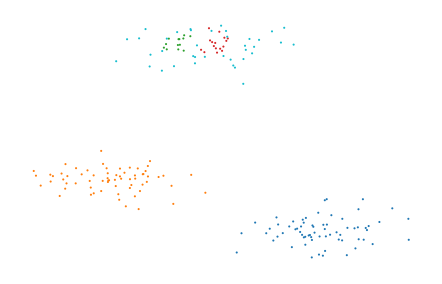

In [ ]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=200, random_state=10)
knn = NearestNeighbors(n_neighbors=50).fit(X).kneighbors(X)
c = PLSCAN(metric='precomputed').fit(knn)

plt.scatter(*X.T, c=c.labels_ % 10, s=1, linewidth=0, cmap="tab10")
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In these cases the leaf and condensed trees may form forests. As a result, these
trees are not compatible with code written for ``hdbscan``.

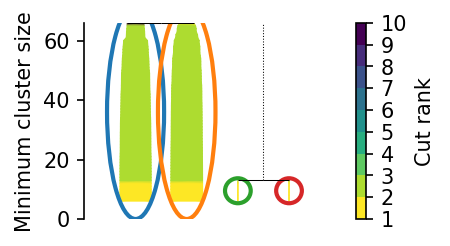

In [ ]:
c.leaf_tree_.plot(select_clusters=True)
plt.show()

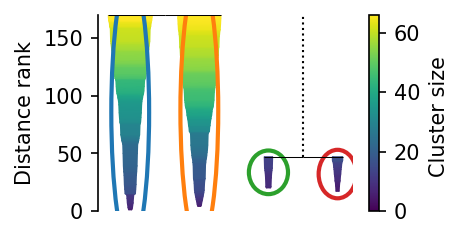

In [ ]:
c.condensed_tree_.plot(select_clusters=True)
plt.show()

## Clustering with sample weights

Like `hdbscan`, `plscan` supports weighted samples as input. This leaf tree has
fewer leaves than the unweighted version because the sample weights are lower
than 1. As a result, more samples need to be combined to reach the minimum
cluster size, resulting in fewer leaf clusters.

One difference to `hdbscan` is `plscan` uses unweighted number of neighbors to
compute core distances (for now).

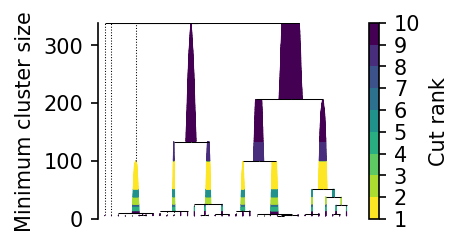

In [50]:
c = PLSCAN().fit(data, sample_weights=np.random.rand(data.shape[0]))
c.leaf_tree_.plot(leaf_separation=0.15)
plt.show()